In [9]:
import numpy as np
import pandas as pd


from sklearn.cross_validation import cross_val_score

import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer,TfidfTransformer
from sklearn import pipeline, preprocessing, feature_extraction
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import os
from sklearn.metrics import accuracy_score

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
d = 'data/pan18-style-change-detection-training-dataset-2018-01-31/'
train_files = os.listdir(d)

truth_files = []
text_files = []
for i in train_files:
    if 'truth' in i:
        truth_files += [i]
    else:
        text_files += [i]
        
truth_files = np.sort(truth_files)
text_files = np.sort(text_files)


texts = []
truths = []
for i, j in zip(text_files, truth_files):
    file = open(d+i, 'r') 
    texts += [file.read()]
    
    file = open(d+j, 'r') 
    truths += [file.read()]
    
df = pd.DataFrame(texts)
df.columns = ['text']
df['coord'] = truths
df['coord'] = df['coord'].apply(lambda x: x.split('[')[1].split(']')[0])


d = 'data/pan18-style-change-detection-validation-dataset-2018-01-31/'
train_files = os.listdir(d)

truth_files = []
text_files = []
for i in train_files:
    if 'truth' in i:
        truth_files += [i]
    else:
        text_files += [i]
        
truth_files = np.sort(truth_files)
text_files = np.sort(text_files)


texts = []
truths = []
for i, j in zip(text_files, truth_files):
    file = open(d+i, 'r') 
    texts += [file.read()]
    
    file = open(d+j, 'r') 
    truths += [file.read()]
    
df_val = pd.DataFrame(texts)
df_val.columns = ['text']
df_val['coord'] = truths
df_val['coord'] = df_val['coord'].apply(lambda x: x.split('[')[1].split(']')[0])


df = pd.concat([df, df_val], axis=0)
df.index = range(len(df))
y = df['coord'].apply(lambda x: len(x) > 0)


df['id'] = range(len(df))


df['text'] = df['text'].apply(lambda x: str(x).lower())
df['text'] = df['text'].apply(lambda x: x.split('.'))

In [11]:
skf = StratifiedKFold(5, shuffle=True, random_state=1)
folds = []
fold_id = 0
df['fold_id'] = np.nan
for itr, ite in skf.split(df, y):
    folds += [[itr, ite]]
    df.ix[ite, 'fold_id'] = fold_id
    fold_id += 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [12]:
all_segments = []
ids = []
f = []
for i in range(len(df)):
    all_segments += df['text'][i]
    ids += [i] * len(df['text'][i])
    f +=  [df['fold_id'][i]] * len(df['text'][i])
seg_df = pd.DataFrame()
seg_df['id'] = ids
seg_df['sent'] = all_segments
seg_df['fold_id'] = f

seg_df['sent'] = seg_df['sent'].apply(lambda x: x.split())

In [13]:
X = map(lambda x: ' '.join(x), seg_df['sent'])
hw = HashingVectorizer(n_features=1000).fit(seg_df['sent'])
X = pd.DataFrame(hw.transform(X).todense())

seg_df = pd.concat([seg_df.drop(['sent'], axis=1), X], axis=1)
seg_stat = seg_df.groupby('id').mean().drop(['fold_id'], axis=1)
seg_stat.reset_index(inplace=True)

seg_df = pd.merge(seg_df, seg_stat, how='left', on='id')



tmp = seg_df.ix[:,2:1002]
tmp.columns = range(tmp.shape[1])

tmp1 = seg_df.ix[:,1002:2002]
tmp1.columns = range(tmp1.shape[1])

seg_df['sigma'] = np.abs(tmp - tmp1).sum(axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [14]:
df['sigma'] = seg_df.groupby('id')['sigma'].apply(lambda x: x.tolist())
df['sigma_mean'] = df['sigma'].apply(lambda x:  np.convolve(x, np.ones((5,))/5, mode='valid') )

In [15]:
df[:10]

,text,coord,id,fold_id,sigma,sigma_mean
0,[definitely remind anyone looking at your fore...,"1204, 4225, 5431",0,1.0,"[6.516261687634313, 6.44899760171332, 5.626261...","[6.108834439864914, 6.145549342119925, 6.17472..."
1,[assuming you'd like to be scrum guide complia...,"1198, 4386",1,2.0,"[5.740876899557552, 4.3914170905511245, 5.9045...","[5.644426737857916, 5.62924675655438, 5.974585..."
2,"[it's all about finding the right balance, i'...",,2,1.0,"[5.499458384623617, 6.88218716436747, 5.175862...","[6.1828631639514695, 6.088887843553811, 5.8859..."
3,[the inbox also suffers from being an unrecogn...,"909, 3045, 4196",3,2.0,"[7.597854604525036, 5.6995534752779005, 5.1323...","[5.857993634763996, 5.634300339934304, 5.55897..."
4,"[second verse, same as the first? it still lac...","2197, 3464",4,0.0,"[5.663519155739532, 5.901500791470362, 6.24590...","[4.829490590935906, 4.869207702999534, 4.86464..."
5,[phase one of this (collecting reasons) should...,,5,2.0,"[6.44600767523278, 5.1816641414927265, 6.83977...","[6.136325972998716, 6.177434962190697, 6.33124..."
6,[you need to show that you can contribute some...,,6,2.0,"[5.247279242234379, 5.785878958818989, 4.17153...","[5.447431525612295, 5.614245763699772, 5.76086..."
7,[what can we do to encourage people to use the...,,7,0.0,"[6.2581987515594255, 6.6151414827756785, 7.376...","[6.0960325891946585, 6.017765349312263, 5.8268..."
8,[database dumps have since been made available...,"1053, 3315",8,3.0,"[7.417119933968278, 5.863831848455949, 5.57932...","[6.2849999059940345, 5.955423165358091, 6.1441..."
9,"[for these shadow answers, editing should be l...","2396, 3467",9,2.0,"[7.23338777427082, 5.11681207229813, 6.4546242...","[6.061200869865999, 5.7914606222305345, 6.0221..."


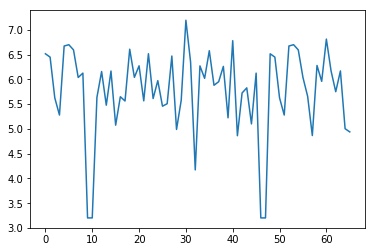

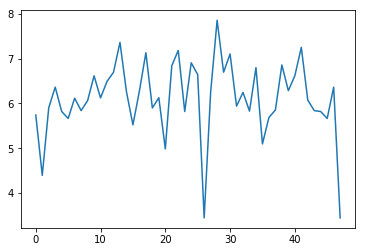

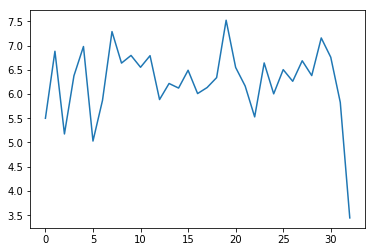

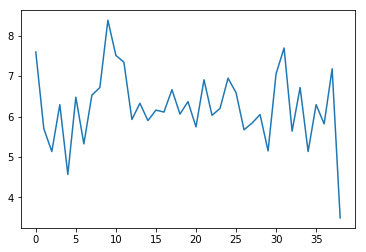

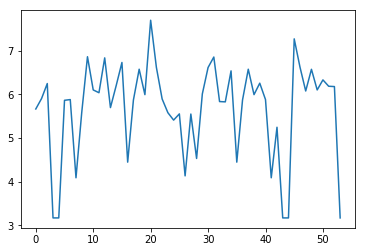

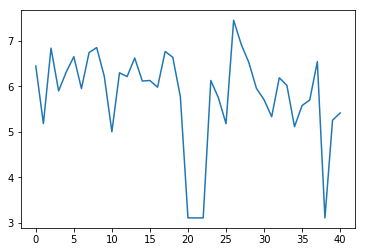

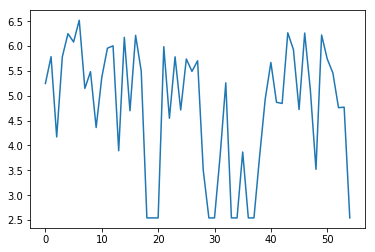

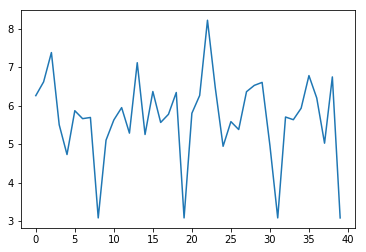

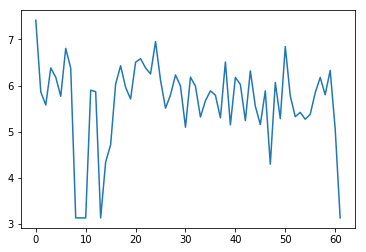

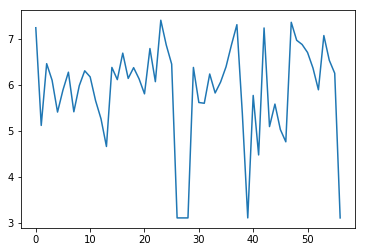

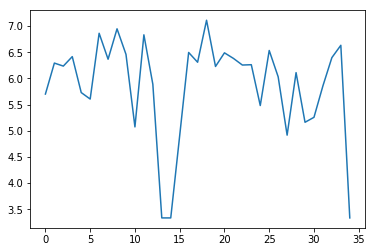

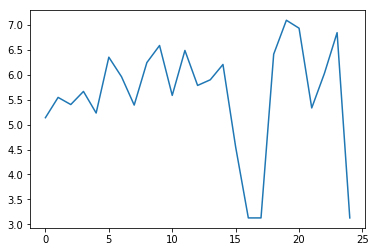

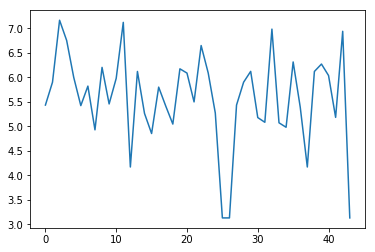

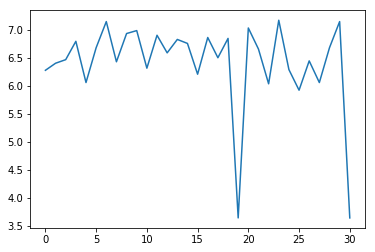

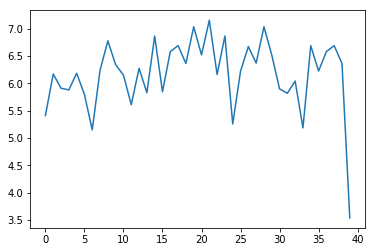

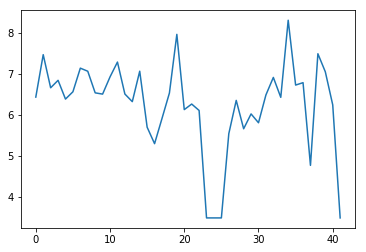

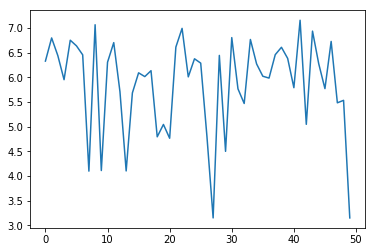

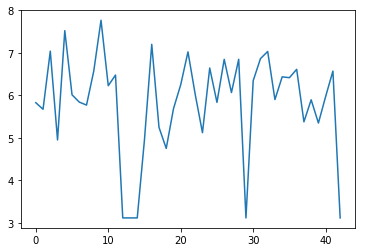

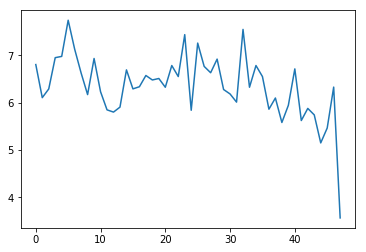

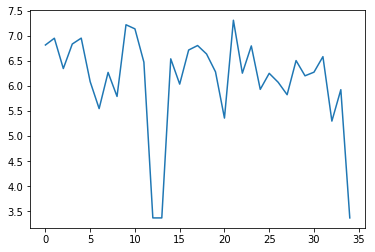

In [38]:
for i in range(20):
    plt.plot(df.ix[i, 'sigma'])
    plt.show()

In [29]:
saf_df = pd.DataFrame()
saf_df['std'] = df['sigma'].apply(lambda x: np.array(x).std())
saf_df['max'] = df['sigma'].apply(lambda x: np.array(x).max())
saf_df['min'] = df['sigma'].apply(lambda x: np.array(x).min())
saf_df['mean'] = df['sigma'].apply(lambda x: np.array(x).mean())
saf_df['median'] = df['sigma'].apply(lambda x: np.median(np.array(x)))
saf_df['max_delt_tot'] = df['sigma'].apply(lambda x: np.abs((x - np.array(x).mean())).max() )
saf_df['max_delt'] = df['sigma'].apply(lambda x: np.abs((np.array(x)[1:]-np.array(x)[:-1])).max()   )

In [30]:
saf_df['std_'] = df['sigma_mean'].apply(lambda x: np.array(x).std())
saf_df['max_'] = df['sigma_mean'].apply(lambda x: np.array(x).max())
saf_df['min_'] = df['sigma_mean'].apply(lambda x: np.array(x).min())
saf_df['mean_'] = df['sigma_mean'].apply(lambda x: np.array(x).mean())
saf_df['median_'] = df['sigma_mean'].apply(lambda x: np.median(np.array(x)))
saf_df['max_delt_tot_'] = df['sigma_mean'].apply(lambda x: np.abs((x - np.array(x).mean())).max() )
saf_df['max_delt_'] = df['sigma_mean'].apply(lambda x: np.abs((np.array(x)[1:]-np.array(x)[:-1])).max()   )

In [36]:
from sklearn.preprocessing import MinMaxScaler
saf_df = pd.read_csv('data/saf_feat.csv')
saf_df = pd.DataFrame(MinMaxScaler().fit_transform(saf_df) )

In [32]:
saf_df.to_csv('data/saf_feat.csv',index=False)

In [37]:
#LGBM
params = {
    #'task': 'train',
    #'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'application': 'multiclass',
    'objective':'binary',
    #'num_leaves': 31,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'subsample': 0.8,
    #'colsample_bytree': 0.8,
    #'objective': 'multiclass',
    'nthread': -1,
    'learning_rate': 0.05,
    #'min_child_weight': 50,
    'max_depth': 2
    #'num_class': 2302,
    #'feature_fraction':0.2,
    #'bagging_fraction':0.5
    
}


pred_train = np.zeros(len(df))
scores = []
for itr, ite in folds:
    train = saf_df.ix[itr,:]
    val = saf_df.ix[ite,:]
    y_train = y[itr]
    y_val = y[ite]
    lgb = lgbm.sklearn.LGBMClassifier(n_estimators=400, seed=0, **params)
    lgb.fit(train, y_train.values)
    ypred = lgb.predict_proba(val)[:, 1]
    
    scores += [accuracy_score(y_val, ypred > 0.5)]
    
scores = np.array(scores)
print(scores.mean(), ' +-', scores.std())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.6283537072547141  +- 0.009625306701266606


In [ ]:
0.6283537072547141  +- 0.009625306701266606

0.6245540707893895  +- 0.007947586133600469

0.6214235778203899  +- 0.009628464122882145

0.6135985937999361  +- 0.012229145752629093

0.6122538151166508  +- 0.010504661515122573

0.5898934364014061  +- 0.010841674646103274

0.5834117329817833  +- 0.010629236725590468

0.5831855225311602  +- 0.00845969082422209


In [48]:
saf_df

,std,max,min,mean,median,std_,max_,min_,mean_,median_
0,0.875503,7.193583,3.202287,5.771984,5.966992,0.418519,6.426325,4.691764,5.774046,5.852178
1,0.847876,7.861716,3.440028,6.122313,6.126597,0.302233,6.771640,5.426119,6.204705,6.203545
2,0.745713,7.522058,3.443516,6.257581,6.376971,0.213552,6.812899,5.885973,6.353064,6.360532
3,0.900731,8.384865,3.487754,6.237190,6.199271,0.404156,7.298259,5.558971,6.278732,6.250253
4,1.091771,7.695857,3.168265,5.679596,5.897516,0.577478,6.554313,4.309501,5.710285,5.838596
5,1.043674,7.453007,3.108269,5.800970,6.020543,0.635140,6.511733,4.240286,5.827591,6.087787
6,1.279168,6.518964,2.542953,4.751686,5.123057,0.852628,5.956135,2.808054,4.763837,5.140577
7,1.111640,8.215521,3.083545,5.687548,5.738484,0.393814,6.336478,5.006238,5.686484,5.820743
8,0.937644,7.417120,3.131050,5.636560,5.854011,0.533068,6.536429,4.232667,5.642552,5.729377
9,1.086456,7.395650,3.112820,5.861748,6.109066,0.561359,6.847975,4.265037,5.871688,5.926859


In [33]:
y_pred = lgb.predict_proba(Y1)[:,1]
accuracy_score(y_val, y_pred > 0.5)

0.6467828418230563

In [24]:
0.6812546228946561
0.6794425548455621
0.6595174262734584

In [27]:
y_val.shape

(1492,)

In [30]:
y_val.sum() / len(y_val)

0.5